# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- Mohammed-Ismail Ben Salah,
    2- Luca Fetz,
    3- Carla Nannini

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

## Part 0: Loading the data

In [1]:
import os
import tarfile
import numpy as np
import scipy as scp
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

#  Folder extraction
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'project-data'
data_projet_path  = os.path.join(data_base_path,data_folder)
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
if not os.path.exists(data_projet_path):
    with tarfile.open(tar_path, mode='r:gz') as tar:
        tar.extractall(path=data_base_path)

# Data project path
img_projet_path   = os.path.join(data_projet_path,'images')
annot_projet_path = os.path.join(data_projet_path,'annotations')
# Read files that contains names
val_name_file  ='validation.txt'
test_name_file ='test.txt'
train_name_file='train.txt'

# Validation
val_img_fn_path = os.path.join(data_projet_path,val_name_file)
val_img_names= [line.rstrip('\n') for line in open(val_img_fn_path)]
val_img_fn   = [line +'.jpg' for line in val_img_names]
val_img_path = [os.path.join(os.path.join(img_projet_path,'validation'),line) for line in val_img_fn]
val_ic = skimage.io.imread_collection(val_img_path)
print('Number of validation images: ', len(val_ic))

# Train
tr_img_fn_path = os.path.join(data_projet_path,train_name_file)
tr_img_names= [line.rstrip('\n') for line in open(tr_img_fn_path)]
tr_img_fn   = [line +'.jpg' for line in tr_img_names]
tr_img_path = [os.path.join(os.path.join(img_projet_path,'train'),line) for line in tr_img_fn]
tr_ic = skimage.io.imread_collection(tr_img_path)
print('Number of validation images: ', len(tr_ic))

# Test
tst_img_fn_path = os.path.join(data_projet_path,test_name_file)
tst_img_names= [line.rstrip('\n') for line in open(tst_img_fn_path)]
tst_img_fn   = [line +'.jpg' for line in tst_img_names]
tst_img_path = [os.path.join(os.path.join(img_projet_path,'test'),line) for line in tst_img_fn]
tst_ic = skimage.io.imread_collection(tst_img_path)
print('Number of test images: ', len(tst_ic))

Number of validation images:  150
Number of validation images:  800
Number of test images:  50


In [2]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

# Xml annotations
val_xml_path = os.path.join(annot_projet_path, 'validation')
val_xmls = [parse_file(os.path.join(val_xml_path,name + '.xml')) for name in val_img_names]

tr_xml_path = os.path.join(annot_projet_path,'train')
tr_xmls = [parse_file(os.path.join(tr_xml_path,name + '.xml')) for name in tr_img_names]

tst_xml_path = os.path.join(annot_projet_path,'test')
tst_xmls = [parse_file(os.path.join(tst_xml_path,name + '.xml')) for name in tst_img_names]

## Part 1: Finding varroas by segmentation
Explain our stuff

In [3]:
# Import stuff
from skimage.filters import threshold_li
from skimage.color   import rgb2gray
from skimage.measure import label
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

def pipeline(rgb_input_img):
    """ Input : RGB image of varroa infection
        Ouput : Binary image of detected varroa 
        Function : Process the image in order to keep the relevant informations """
    # Principal pipeline 
    # Preprocessing
    # Contrast enhancement
    sigmoid_p = 0.5
    rgb_input_img = skimage.exposure.adjust_sigmoid(rgb_input_img, cutoff=sigmoid_p, gain=10, inv=False)    
    
    # Color Selection
    single_canal = False
    input_img = rgb2gray(rgb_input_img)
    
    # Morphology operations
    struct_elem = disk(4)
    morph_img   = dilation(input_img, struct_elem)# Remove waste on images
    struct_elem = disk(4)
    morph_img   = erosion(morph_img,struct_elem) # Give proportion again to varroa
    
    # Thresholding
    
    # Li method thres.
    li_thres = threshold_li(morph_img)
        
    # Binarization
    bin_min  = morph_img < li_thres

    # Plot the results
    plot_processing = False
    if True == plot_processing:
        fig, axes = plt.subplots(ncols=3, figsize=(15, 15))
        ax = axes.ravel()

        ax[0].imshow(input_img)
        ax[0].set_xlabel('Orig.')

        ax[1].imshow(morph_img)
        ax[1].set_xlabel('Morph. processing.')

        ax[2].imshow(bin_min)
        ax[2].set_xlabel('Minimal thres.')
        plt.show()
        
    # Assign the output to final processing
    output = bin_min
    
    return output

def label_varroa_region(input_image):
    """ Input  : Binary image of detected varroa
        Output : Multiples labellised regions of the image"""
    output_labels,num_labels = label(input_image,return_num=True,connectivity=None)
    return output_labels

In [4]:
from skimage.measure import regionprops

def xml_annotation_to_bbox(xml_annotation):
    """ Convert an xml annotation to a list of bbox tuples"""
    bbox_list = []
    for elem in xml_annotation:
        bbox_coords = elem['bbox']
        bbox_tuple  = tuple(bbox_coords)
        bbox_list.append(bbox_tuple)
    
    return bbox_list

def iou_bbox2(gt_reg,pred_reg):
    """ 
        Compute the IoU between two region with their bounding boxes
         
        Parameters
        ----- 
        pred_reg format : (MIN_ROW,MIN_COL,MAX_ROW-MIN_ROW,MAX_COL-MIN_COL)
        pred_reg pixels in bounding box are in half-open interval [min_row; max_row) and [min_col; max_col).
        gt_reg h-format : (x, y, width, heigth) in some cartesian form
        gt_reg format   : (MIN_COL,MIN_ROW, MAX_ROW-MIN_ROW, MAX_COL-MIN_COL)
        
        Return
        -----
        float val in [0,1]
    """
    # x:rows and y:colummns are (0,0) at right corner
    
    # Harmonize the coordinates systems of the bounding boxes
    g_x_min,g_y_min,diff_x,diff_y = gt_reg
    g_y_max = g_y_min + diff_y 
    g_x_max = g_x_min + diff_x
    
    # In ground truth max_values are inside the bbox but in label are outside 
    p_x_min,p_y_min,p_diff_x,p_diff_y = pred_reg
    # Correction of max values
    p_x_max = p_x_min + p_diff_x
    p_y_max = p_y_min + p_diff_y
    
    # Determine the (x,y) coordinates of the intersection rectangle
    i_x_min = max(p_x_min,g_x_min)
    i_y_min = max(p_y_min,g_y_min)
    i_x_max = min(p_x_max,g_x_max)
    i_y_max = min(p_y_max,g_y_max)
    
    # Compute the intersection area (robust to non-matching rect.s)
    inter_area = max(0,i_x_max -  i_x_min + 1) * max(0,i_y_max - i_y_min + 1)
    
    
    # Compute the area of both the prediction and the ground-truth
    pred_rect = (p_x_max-p_x_min+1)*(p_y_max-p_y_min+1) 
    gt_rect   = (g_x_max-g_x_min+1)*(g_y_max-g_y_min+1)

    debug_print = False
    
    if True == debug_print:
        print(" GT : {}:{}/{}:{}".format(g_x_min,g_y_min,g_x_max,g_y_max))
        print(" PR : {}:{}/{}:{}".format(p_x_min,p_y_min,p_x_max,p_y_max))
        print("INTER : {}".format(inter_area))
        print("PRED_AREA : {}".format(pred_rect))
        print("GT   AREA : {}".format(gt_rect))
    
    # Compute the intersection over union
    iou_val = inter_area/(gt_rect+pred_rect-inter_area)
    return iou_val

def detection_statistics_2(pred_labels,gt_labels,threshold):
    """
    
    Returns a tuple composed by pred_region_stats and gt_region_stats
    
    Parameters
    ------
    pred_labels : list of bbox tuples per predicted region
    gt_labels   : list of bbox tuples per ground truth region
    threshold   : IoU threshold
    
    Returns
    ------
    (pred_region_stats,gt_region_stats)
    
    pred_region_stats :
    a list of size of number of predicted region having the following status depending on the IoU criteria
    3 : True  positive (region is correct)
    1 : False positive (region doesn't exist in ground truth or don't match enough)
    
    gt_region_stats :
    a list of size of number of ground truth region having the following status depending on the IoU criteria
    0 : Region being detected
    -3: False negative (existing region not detected)
    """
    debug_print = False # Variable to enable debuging information  
        
    pred_region_status = np.zeros(len(pred_labels)) # Select between true or false positive
    pred_region_argmax = np.zeros(len(pred_labels)) # Array that stores the best IoU idx per predicted region
    gt_region_status = np.zeros(len(gt_labels))    # Store if ground truth region is being detected.
    
    # Rows : Gt regions,Cols : Predicted regions
    iou_array = np.zeros((len(gt_labels),len(pred_labels)),dtype=np.float64)     
    
    # Compute all the IoU bruteforce method
    for idx_a,a in enumerate(gt_labels):
        for idx_b,b in enumerate(pred_labels):
            # Debug info begin
            if True == debug_print:
                print("gt_idx {} / reg_idx {} ".format(idx_a,idx_b))
                print("Bbox coords ----------")
                print("GT : {}\nPRED : {}".format(a,b))
            # Debug info end
            iou_array[idx_a,idx_b] = iou_bbox2(a,b)
    
    # Debug info begin
    if True == debug_print:
        print("--------------")
        print("mtx size : {}",iou_array.shape)
        print(iou_array)
        print("--------------")
    # Debug info end
    
    # Compute the false positive (pred region which IoU equals 0 over the ground truth is equal to zero)
    false_pos_idx = [iou_array.sum(0) == 0]
    pred_region_status[false_pos_idx] = 1.0 # False positive
    pred_region_argmax[false_pos_idx] = -1.0 # False positive then no assignation to a region
    
    # Compute the true positive depending on the threshold
    for pred_idx,elem in enumerate(pred_region_status):
        if elem != 1.0:
            gt_idx = iou_array[:,pred_idx].argmax() # Get the maximum IoU
            # Check if IoU is above the threshold
            if iou_array[gt_idx,pred_idx] >= threshold:
                pred_region_status[pred_idx] = 3. # True positive
                pred_region_argmax[pred_idx] = gt_idx # Assign the predicted region to a ground truth region
            else:
                pred_region_status[pred_idx] = 1.   # False positive
                pred_region_argmax[pred_idx] = -1.0 # False positive then no assignation to a region       
                
    # Compute the false negative
    for idx,elem in enumerate(gt_region_status):
        if idx not in pred_region_argmax: # If no predicted region has been assigned to a ground truth region
            gt_region_status[idx] = -3.0 # False negative
    
    return (pred_region_status,gt_region_status)

In [5]:
def precision(region_stats,gt_stats):
    """ Compute the precision of the image detection tp/tp+fp"""
    unique,counts = np.unique(region_stats, return_counts=True) # Get the list of number and # of occurences
    stats_dict = dict(zip(unique,counts))
    tp = stats_dict.get(3.0,0.0) # Get the number of true positive
    fp = stats_dict.get(1.0,0.0) # Get the number of false positive 
    
    # If nothing is detected then return zero (avoid numerical error)
    if 0.0 == tp+fp:
        return 0.0
    else:
        return tp/(tp+fp)

def recall(region_stats,gt_stats):
    """ Compute the recall of the image detection tp/tp+fn"""
    
    unique,counts = np.unique(region_stats, return_counts=True) # Get the list of number and # of occurences
    stats_dict = dict(zip(unique,counts))
    tp = stats_dict.get(3.0,0.0) # Get the number of true positive
    
    unique,counts = np.unique(gt_stats, return_counts=True) # Get the list of number and # of occurences
    stats_dict = dict(zip(unique,counts))
    fn = stats_dict.get(-3.0,0.0) # Get the number of false negative 
    
    # If nothing is detected then return zero (avoid numerical error)
    if 0.0 == tp+fn :
        return 0.0
    else:
        return tp/(tp+fn)

def f1_score(region_stats,gt_stats,verbose=False):
    """"""
    rec  = recall(region_stats,gt_stats)
    prec = precision(region_stats,gt_stats)
    
    # If nothing is detected then return zero (avoid numerical error)
    if 0. == prec or 0. == rec:
        f1_val = 0.0
    else:
        f1_val = 2*prec*rec/(rec+prec)
    if True == verbose: 
        print("Stats : Rec : {} / Prec : {} / F1-score : {}".format(rec,prec,f1_val))
    return (rec,prec,f1_val)

In [6]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    bin_img = pipeline(img)
    label_img = label_varroa_region(bin_img)
    props_list = regionprops(label_img) # Properties of the labelled image
    bbox_list = []
    for elem in props_list:
            min_r,min_c,max_r,max_c = elem.bbox
            bbox_list.append((min_c,min_r,max_c-min_c,max_r-min_r))
                             
    return bbox_list
    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [7]:
# Process the images and print some statistics
stat_list = []
for idx,img in enumerate(tst_ic):
    bin_img = pipeline(img)
    label_img = label_varroa_region(bin_img)
    pred_labels = detect_by_segmentation(img) 
    gt_labels   = xml_annotation_to_bbox(tst_xmls[idx])
    # Proceed to gather statistics
    thres_list =  [0.3]
    for thres in thres_list:
        reg_stats,gt_stats = detection_statistics_2(pred_labels,gt_labels,thres)
        stat_list.append(f1_score(reg_stats,gt_stats))
        

C:\Users\Ismail-P51\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Ismail-P51\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [8]:
print('Final results')
stat_array  = np.array(stat_list).reshape(len(tst_ic),3)      
print("Array shape {} ".format(stat_array.shape))
best_f1_idx = np.argmax(stat_array[:,2],axis=0)
print('Best detection : Recall : {}, Precision :  {}, F1-score : {}'.format(stat_array[best_f1_idx][0],stat_array[best_f1_idx][1],stat_array[best_f1_idx][2]))

print('Mean detection (stats)\nRecall : {}/{}\nPrecision : {}/{}\nF1-score : {}/{}'
                          .format(
                              np.mean(stat_array[:,0]),
                              np.std(stat_array[:,0]),
                              np.mean(stat_array[:,1]),
                              np.std(stat_array[:,1]),
                              
                              np.mean(stat_array[:,2]),
                              np.std(stat_array[:,2]),
                                 ) )

Final results
Array shape (50, 3) 
Best detection : Recall : 0.8, Precision :  0.6666666666666666, F1-score : 0.7272727272727272
Mean detection (stats)
Recall : 0.48977554347959235/0.43370147819842864
Precision : 0.04112408000451433/0.10729990269152287
F1-score : 0.06015054081620241/0.12371472060260157


## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

### Implementation
Detector implementation is done like this: the method detect_by_method_1 takes as input an image, compute windows of given size and iterate over all the windows to describe and classify the content of the window with the methods describe() and classify(). The method describe() implements a canny edge detector and returns the edge length. The method classify() compare this length to a threshold to choose if there is a varroa.

In [9]:
#implement desriptor and classifier for method 1
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature

def describe_1(im):
    '''
    input: an image
    output: descriptor (detected edge with canny filter)
    '''
    # Compute the Canny filter for two values of sigma
    edge = feature.canny(im, sigma=1)
    
    #calculate descriptor, here edge length
    edge_length = np.sum(edge)
    return edge_length
    
def classify_1(descriptor):
    has_varroa = False
    thres1 = 80
    thres2 = 120
    if descriptor > thres1:
        if descriptor < thres2:
            has_varroa = True
    return has_varroa

In [10]:
#method 1 to detect varroas
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    #initialize list of varroas empty
    output = []
    
    #do a sliding window. the last band on rows and columns is ignored if the img is not a multiple of the stepsize
    stepSize = 30
    windowSize = 30
    for y in range(0, img.shape[0]-1, stepSize):
        for x in range(0,img.shape[1]-1, stepSize):
            #create the window
            window = img[y:(y+windowSize),x:(x+windowSize)]
            
            #describe window
            descriptor = describe_1(window)
            
            #classify window
            has_varroa = classify_1(descriptor)
            
            #if classified as a varroa keep window as the bbox
            if has_varroa:
                bbox = [x,y,windowSize,windowSize]
                output.append(bbox)
    
    return output

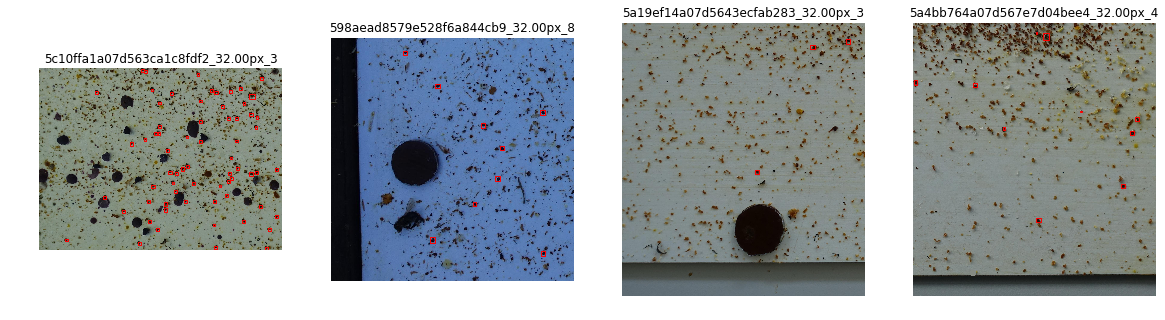

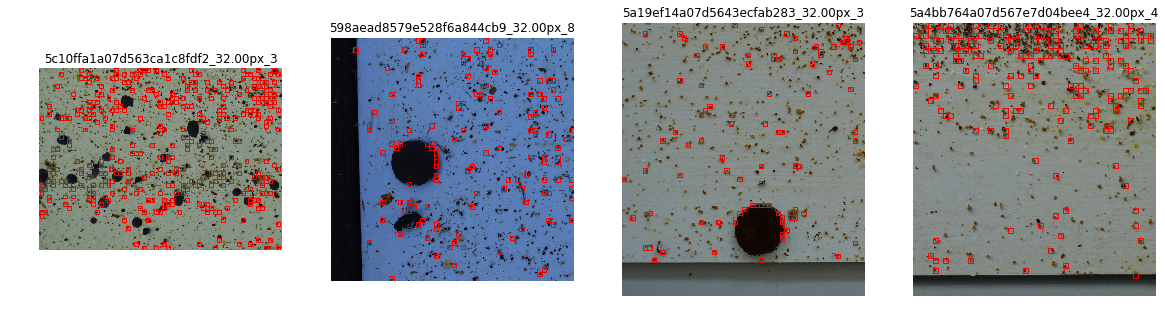

In [11]:
# Plot images of ground truth vs predicted for a few images
begin = 20
end = 24

fig, axes = plt.subplots(1, 4, figsize=(20, 20))
for ax, im, nm, annotations in zip(axes.ravel(), tr_ic[begin:end], tr_img_names[begin:end], tr_xmls[begin:end]):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(20, 20))
for ax, im, nm, annotations in zip(axes.ravel(), tr_ic[begin:end], tr_img_names[begin:end], tr_xmls[begin:end]):
    gray_img = rgb2gray(im)
    detected_varroa = detect_by_method_1(gray_img)
    # Iterate over annotations
    for anno in detected_varroa:
        rect = patches.Rectangle((anno[0], anno[1]), anno[2], anno[3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [12]:
print("Canny Edge detection")

# Process the images and print some statistics
stat_list = []
for idx,img in enumerate(tst_ic):
    gray_img = rgb2gray(img)
    pred_labels = detect_by_method_1(gray_img)
    gt_labels   = xml_annotation_to_bbox(tst_xmls[idx])
    thres_list =  [0.3]
    for thres in thres_list:
        reg_stats,gt_stats = detection_statistics_2(pred_labels,gt_labels,thres)
        stat_list.append(f1_score(reg_stats,gt_stats))
        

Canny Edge detection


C:\Users\Ismail-P51\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Ismail-P51\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [13]:
print('Final results')
stat_array  = np.array(stat_list).reshape(len(tst_ic),3)      
print("Array shape {} ".format(stat_array.shape))
best_f1_idx = np.argmax(stat_array[:,2],axis=0)
print('Best detection : Recall : {}, Precision :  {}, F1-score : {}'.format(stat_array[best_f1_idx][0],stat_array[best_f1_idx][1],stat_array[best_f1_idx][2]))

print('Mean detection (stats)\nRecall : {}/{}\nPrecision : {}/{}\nF1-score : {}/{}'
                          .format(
                              np.mean(stat_array[:,0]),
                              np.std(stat_array[:,0]),
                              np.mean(stat_array[:,1]),
                              np.std(stat_array[:,1]),
                              
                              np.mean(stat_array[:,2]),
                              np.std(stat_array[:,2]),
                                 ) )

Final results
Array shape (50, 3) 
Best detection : Recall : 0.5, Precision :  0.2222222222222222, F1-score : 0.30769230769230765
Mean detection (stats)
Recall : 0.19132891076931327/0.2638740785441649
Precision : 0.024741819004594524/0.04735931426226018
F1-score : 0.0382271202134868/0.06732459182304976


## Part 3: Using MLP and CNNs

Add your implementation for the third part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [ ]:
#Implement fucking YOLO


## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [ ]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [ ]:
#Your code